In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix
#from sklearn.model_selection import KFold

In [2]:
# Function to set appropriate figure size for publication
# Width @516pts is for IEEE conference format
def set_size(width=516, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [3]:
# Data params
textures = 11
trials = 100

# Set bin and sim params
bin_size = 100   # Bin size in ms
sim_length = 5000   # Sim time in ms
bins = sim_length / bin_size

In [4]:
# Import dataset and labels from pickle
PATH = "/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/datasets/TacTip_NM/histogram_classifier/"
DATA_NAME = str(sim_length) + "ms - " + str(bin_size) + "ms bin size dataset.pickle"
LABEL_NAME = str(textures) + " textures - " + str(trials) + " trials labels.pickle"

# Import dataset first
FILENAME = PATH + DATA_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        dataset = pickle.load(openfile)
    except EOFError:
        print(EOFError)
        
# Now import label array
FILENAME = PATH + LABEL_NAME

# Create array of intensities for heatmap
with(open(FILENAME, "rb")) as openfile:
    try:
        labels = pickle.load(openfile)
    except EOFError:
        print(EOFError)

In [5]:
#print(len(dataset))

In [6]:
# WARNING: Dataset created from previous script contains a NULL row 0
#          This row has currently been deleted and saved over the initial dataset
#          Note for next time is to fix this bug
#print(dataset[0])
#dataset = np.delete(dataset, 0, 0)
#print(len(dataset))
if len(dataset) == 1101:
    dataset = np.delete(dataset, 0, 0)
    
# Split data into testing and training
# Ration currently 80-20
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2)

In [7]:
# Create kfold validation model
kf = KFold(n_splits=10, random_state=63, shuffle=True)

In [8]:
# Use sklearn accuracy metrics to asses
# Test over a range of neighbour numbers
# TO DO: Use KFold cross validation for this method

max_n = 20

# accuracy_scores = []
# recall_scores = []
# precision_scores = []
train_accuracies = [[] for _ in range(max_n)]
val_accuracies = [[] for _ in range(max_n)]

x_train = np.array(x_train)
y_train = np.array(y_train)

# Total confusion arrays
Y_true = []
Y_Pred = []


for n in range(max_n):
    
    knn = KNeighborsClassifier(n_neighbors=n+1)
    
    # Loop through each of the folds within the kfold
    for train_index, val_index in kf.split(x_train):
        # Create folded data
        Xtrain, Xval = x_train[train_index], x_train[val_index]
        ytrain, yval = y_train[train_index], y_train[val_index]
        
        # Fit the model to the new folded training data
        knn.fit(Xtrain, ytrain)

        # Precit value using KNN
        #y_pred = knn.predict(x_test)
        pred_train = knn.predict(Xtrain)
        pred_val = knn.predict(Xval)
        
        # Append values to seperate array for confusion matrix
        Y_true.append(yval)
        Y_Pred.append(pred_val)

        #Calculate the accuracy of the predictions on the training set 
        #and save in the variable train_accuracies
        train_accuracies[n].append(accuracy_score(ytrain, pred_train))
        train_accuracies[n].append(recall_score(ytrain, pred_train, average='micro'))
        train_accuracies[n].append(precision_score(ytrain, pred_train, average='micro'))
        
        #Do the same for the predictions on the validation set
        ###TODO###
        val_accuracies[n].append(accuracy_score(yval, pred_val))
        val_accuracies[n].append(recall_score(yval, pred_val, average='micro'))
        val_accuracies[n].append(precision_score(yval, pred_val, average='micro'))

In [9]:
#Calculate the mean for training and validation accuracies
train_accuracy_mean = np.mean(train_accuracies, axis=1)
val_accuracy_mean = np.mean(val_accuracies, axis=1)

In [10]:
#print(np.mean(train_accuracy_mean))
print(np.mean(val_accuracy_mean))
print(np.max(val_accuracies))

0.8526704545454546
0.9886363636363636


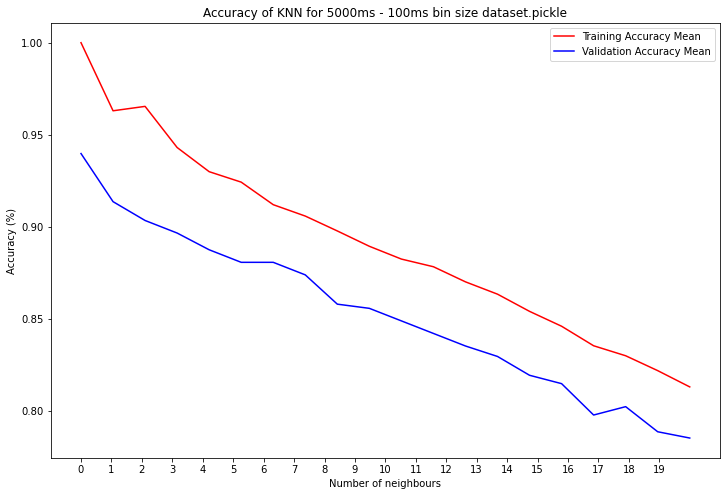

In [11]:
# Plot this data
x = np.linspace(0, max_n, 20)

fig, ax = plt.subplots(figsize=(12,8))


ax.plot(x, train_accuracy_mean, color='r',label='Training Accuracy Mean')
ax.plot(x, val_accuracy_mean, color='b',label='Validation Accuracy Mean')
plt.xlabel("Number of neighbours")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy of KNN for " + DATA_NAME)
# plt.savefig("/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/clipped_classifier_results/" +
#                     DATA_NAME + ".png")
ax.legend()
plt.xticks(np.arange(0,20,1))
plt.show()

In [12]:
SAVE_PATH = '/home/farscope2/Documents/PhD/Spiking Nets Project/SpikingNetsTexture/graphs/paper_confusion/'

In [13]:
Y_true = [item for sublist in Y_true for item in sublist]
#print(Y_true)
Y_Pred = [item for sublist in Y_Pred for item in sublist]

In [14]:
cnf_matrix = confusion_matrix(Y_true, Y_Pred)

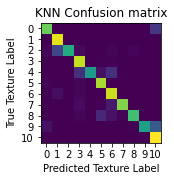

array([[1345,    0,    0,    0,    0,    0,    0,    0,    0,    2,  273],
       [   0, 1660,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  22,  359, 1067,   45,    0,    0,   24,    2,   21,    0,    0],
       [   0,    0,    0, 1569,    0,   13,   18,    0,    0,    0,    0],
       [   0,    0,    0,  240,  931,   76,  243,   10,    0,    0,    0],
       [  19,    0,    0,   30,    1, 1510,    0,    0,    0,    0,    0],
       [   0,   62,    0,   26,    0,    0, 1592,    0,    0,    0,    0],
       [   0,    0,    0,   54,    6,   18,  128, 1413,    1,    0,    0],
       [   0,    0,    0,   27,    5,  197,   87,   14, 1210,    0,    0],
       [  80,    0,    0,    0,    0,    0,    0,    0,    0,  979,  481],
       [   1,    0,    0,    0,    0,    0,    0,    0,    0,    8, 1731]])

In [15]:
plt.figure(figsize=set_size(fraction=0.5))
plt.xticks(range(11))
plt.yticks(range(11))
plt.imshow(cnf_matrix)
plt.title('KNN Confusion matrix')
plt.xlabel("Predicted Texture Label")
plt.ylabel("True Texture Label")
plt.savefig(SAVE_PATH + DATA_NAME + " KNN confusion.eps", bbox_inches="tight")
plt.show()
cnf_matrix

In [16]:
# norm = np.linalg.norm(cnf_matrix)
# normal_cnf = cnf_matrix/norm

# plt.figure(figsize=(6, 6))
# plt.xticks(range(11))
# plt.yticks(range(11))
# plt.imshow(normal_cnf)
# plt.title('Normalised Confusion matrix')
# plt.savefig(SAVE_PATH + DATA_NAME + " KNN normalised confusion.png")
# plt.show()
# normal_cnf